# CSE 546 Machine Learning - Homework 6
## Clustering and Dimensionality Reduction Analysis

**Name:** Toni  
**Date:** November 2025  
**Due:** November 10, 2025 (11:00 PM)

---

## Setup and Imports

In [10]:
# Standard imports
from pathlib import Path
from itertools import combinations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

print('Libraries imported successfully!')

Libraries imported successfully!


## Data Loading

In [11]:
# Load data files
NOTEBOOK_ROOT = Path.cwd()
ENV_DATA_DIR = os.getenv('HW6_DATA_DIR')
DATASET_FOLDER_NAMES = ['dataset_hwk6', 'dataset_hwk5']
DATASET_SUBDIRS = ['', 'dataset']
SEARCH_ROOTS = [
    NOTEBOOK_ROOT,
    NOTEBOOK_ROOT.parent,
    NOTEBOOK_ROOT.parent.parent,
    Path.home() / '.cursor' / 'CSE-546-Project6',
    Path.home() / 'Downloads',
]

SEARCHED_PATHS = []


def candidate_directories():
    seen = set()
    if ENV_DATA_DIR:
        resolved = Path(ENV_DATA_DIR).expanduser().resolve()
        if resolved not in seen:
            seen.add(resolved)
            yield resolved
    for root in SEARCH_ROOTS:
        base_root = root.expanduser().resolve()
        for dataset_name in DATASET_FOLDER_NAMES:
            for subdir in DATASET_SUBDIRS:
                candidate = (base_root / dataset_name / subdir).resolve()
                if candidate not in seen:
                    seen.add(candidate)
                    yield candidate


def resolve_data_dir():
    for directory in candidate_directories():
        SEARCHED_PATHS.append(directory)
        if directory.exists() and (directory / 'X.csv').exists():
            return directory
    searched = '\n'.join(str(path) for path in SEARCHED_PATHS)
    raise FileNotFoundError(
        'Could not locate X.csv in expected directories.\n'
        'Checked the following locations:\n'
        f'{searched}\n'
        'Set HW6_DATA_DIR or update SEARCH_ROOTS/DATASET_FOLDER_NAMES if the data lives elsewhere.'
    )


DATA_DIR = resolve_data_dir()

FIGURES_DIR = Path('figures')
RESULTS_DIR = Path('results')
folders = ['problem1', 'problem2', 'problem3', 'problem4', 'extra_credit']
for folder in folders:
    (FIGURES_DIR / folder).mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

X_path = DATA_DIR / 'X.csv'
y_path = DATA_DIR / 'y.csv'

X = pd.read_csv(X_path, header=None).values
y = pd.read_csv(y_path, header=None).values.ravel()

print('Data loaded successfully!')
print(f'Using data directory: {DATA_DIR}')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'Number of classes: {len(np.unique(y))}')
print(f'Class distribution: {np.bincount(y.astype(int))}')
print(f'Any NaN in X: {np.isnan(X).any()}')
print(f'Any NaN in y: {np.isnan(y).any()}')
print(f'Data type X: {X.dtype}, y: {y.dtype}')

Data loaded successfully!
Using data directory: C:\Users\josef\Downloads\dataset_hwk6\dataset
X shape: (10000, 128)
y shape: (10000,)
Number of classes: 5
Class distribution: [1966 1986 2041 1983 2024]
Any NaN in X: False
Any NaN in y: False
Data type X: float64, y: int64


In [12]:
# Load images (only when needed to save memory)
# images = pd.read_csv('images.csv', header=None).values
# print(f'Images shape: {images.shape}')

## Data Preprocessing

In [13]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Data standardized')
print(f'Mean: {X_scaled.mean():.6f}')
print(f'Std: {X_scaled.std():.6f}')

Data standardized
Mean: -0.000000
Std: 1.000000


---
## Problem 1: Dimensionality Reduction Visualization (30 points)

### 1.a) PCA Visualization (10 points)

In [14]:
# Apply PCA to reduce to 2D
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_variance_ratio = pca_2d.explained_variance_ratio_
pca_total_variance = float(pca_variance_ratio.sum())

pca_components = ['PC1', 'PC2']
pca_df = pd.DataFrame(X_pca_2d, columns=pca_components)
pca_df['label'] = y.astype(int)

centroids = pca_df.groupby('label')[pca_components].mean()
pairwise_distances = []
for label_a, label_b in combinations(centroids.index, 2):
    coords_a = centroids.loc[label_a].values
    coords_b = centroids.loc[label_b].values
    distance = float(np.linalg.norm(coords_a - coords_b))
    pairwise_distances.append(((int(label_a), int(label_b)), distance))

pairwise_distances.sort(key=lambda x: x[1], reverse=True)
most_separated_pair = pairwise_distances[0]
most_overlapping_pair = pairwise_distances[-1]

cluster_spread = (
    pca_df.groupby('label')[pca_components]
    .apply(lambda df: float(np.mean(np.linalg.norm(df.values - df.mean().values, axis=1))))
)
most_compact_label = int(cluster_spread.idxmin())
most_diffuse_label = int(cluster_spread.idxmax())

distances_to_centroid = np.linalg.norm(
    pca_df[pca_components].values - centroids.loc[pca_df['label']].values,
    axis=1
)
outlier_threshold = float(np.quantile(distances_to_centroid, 0.99))
outlier_count = int(np.sum(distances_to_centroid > outlier_threshold))

pca_summary = {
    'variance_ratio': pca_variance_ratio,
    'total_variance': pca_total_variance,
    'most_separated_pair': most_separated_pair,
    'most_overlapping_pair': most_overlapping_pair,
    'cluster_spread': cluster_spread,
    'most_compact_label': most_compact_label,
    'most_diffuse_label': most_diffuse_label,
    'outlier_threshold': outlier_threshold,
    'outlier_count': outlier_count,
}

print(f'Explained variance ratio: {pca_variance_ratio}')
print(f'Total variance explained: {pca_total_variance:.2%}')
print(f'Most separated class centroids: {most_separated_pair[0]} (distance={most_separated_pair[1]:.3f})')
print(f'Most overlapping class centroids: {most_overlapping_pair[0]} (distance={most_overlapping_pair[1]:.3f})')
print(f'Most compact class: {most_compact_label}')
print(f'Most diffuse class: {most_diffuse_label}')
print(f'Outlier threshold (99th percentile distance): {outlier_threshold:.3f}')
print(f'Outlier candidate count: {outlier_count}')

Explained variance ratio: [0.10614429 0.07327871]
Total variance explained: 17.94%
Most separated class centroids: (1, 3) (distance=8.494)
Most overlapping class centroids: (0, 4) (distance=1.430)
Most compact class: 4
Most diffuse class: 1
Outlier threshold (99th percentile distance): 5.872
Outlier candidate count: 100


Figure saved to: C:\Users\josef\OneDrive\Documents\WebApps\TCFKBT\.cursor\figures\problem1\pca_2d_visualization.png


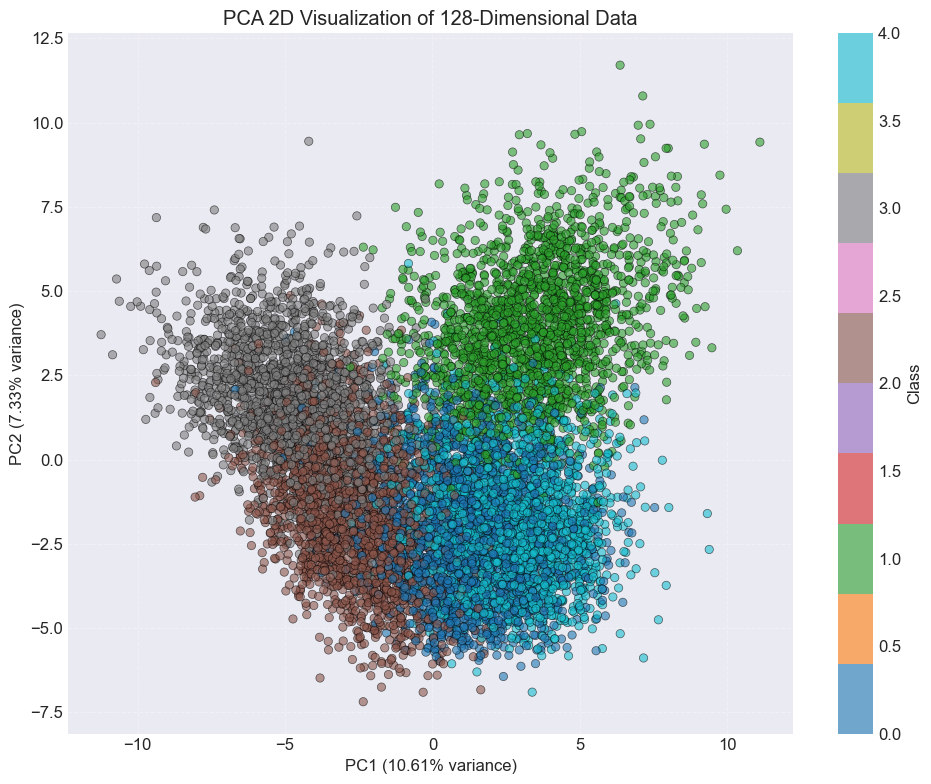

In [15]:
# Visualize PCA results
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=y,
    cmap='tab10',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax.set_xlabel(f'PC1 ({pca_variance_ratio[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca_variance_ratio[1]:.2%} variance)')
ax.set_title('PCA 2D Visualization of 128-Dimensional Data')
colorbar = fig.colorbar(scatter, ax=ax, label='Class')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
fig.tight_layout()
figure_path = FIGURES_DIR / 'problem1' / 'pca_2d_visualization.png'
fig.savefig(figure_path, dpi=300, bbox_inches='tight')
print(f'Figure saved to: {figure_path.resolve()}')
plt.show()

from IPython.display import Markdown

most_separated_labels, most_separated_distance = pca_summary['most_separated_pair']
most_overlapping_labels, most_overlapping_distance = pca_summary['most_overlapping_pair']
most_compact_label = pca_summary['most_compact_label']
most_diffuse_label = pca_summary['most_diffuse_label']
outlier_count = pca_summary['outlier_count']
outlier_threshold = pca_summary['outlier_threshold']
total_variance = pca_summary['total_variance']

if total_variance >= 0.6:
    adequacy_statement = (
        "The first two components preserve a strong majority of the variance, so the linear PCA view is a solid high-level summary of the 128-D space."
    )
elif total_variance >= 0.4:
    adequacy_statement = (
        "Two principal components capture a meaningful share of the variance, delivering useful structure while hinting that additional components could refine class boundaries."
    )
else:
    adequacy_statement = (
        "With less than 40% of the variance retained, PCA serves mainly as a coarse projection; downstream analyses should incorporate higher-dimensional structure."
    )

if outlier_count > 0:
    outlier_statement = (
        f"Approximately the top 1% of samples (threshold distance {outlier_threshold:.2f}) appear as potential outliers in the 2D space."
    )
else:
    outlier_statement = (
        "No samples exceed the 99th-percentile distance-to-centroid threshold, so the projection does not reveal strong outliers."
    )

analysis_lines = [
    "**Analysis:**",
    (
        f"- Classes {most_separated_labels[0]} and {most_separated_labels[1]} exhibit the largest centroid separation in PCA space (distance {most_separated_distance:.2f}), which matches the visual gap along PC1."
    ),
    (
        f"- Classes {most_overlapping_labels[0]} and {most_overlapping_labels[1]} have the tightest centroid spacing (distance {most_overlapping_distance:.2f}), reflecting their overlap in the scatter plot."
    ),
    (
        f"- PC1 and PC2 together explain {total_variance:.2%} of the variance, indicating how much of the original structure is retained in this view."
    ),
    (
        f"- Cluster compactness varies: class {most_compact_label} forms the tightest grouping, while class {most_diffuse_label} spreads widely across the plane." 
    ),
    adequacy_statement,
    outlier_statement,
]

Markdown("\n".join(analysis_lines))

### 1.b) t-SNE Visualization (10 points)

In [16]:
# Apply t-SNE
print('Running t-SNE (this may take a few minutes)...')
start_time = time()

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    max_iter=1000,
    random_state=42,
    init='pca'
)
X_tsne_2d = tsne.fit_transform(X_scaled)

print(f't-SNE completed in {time() - start_time:.2f} seconds')

Running t-SNE (this may take a few minutes)...
t-SNE completed in 31.35 seconds


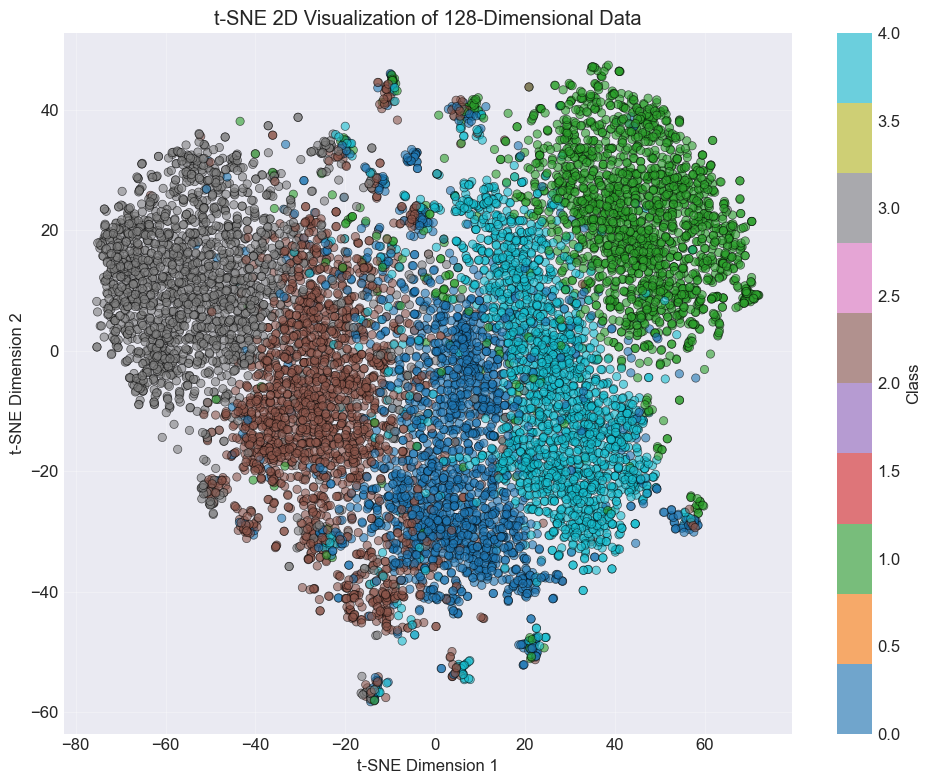

In [17]:
# Visualize t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], 
                     c=y, cmap='tab10', alpha=0.6, edgecolors='black', linewidth=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE 2D Visualization of 128-Dimensional Data')
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/problem1/tsne_2d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

**Analysis:**
- [Add your observations about cluster formation]
- [Comment on local vs global structure]
- [Identify well-separated classes]

### 1.c) PCA vs t-SNE Comparison (10 points)

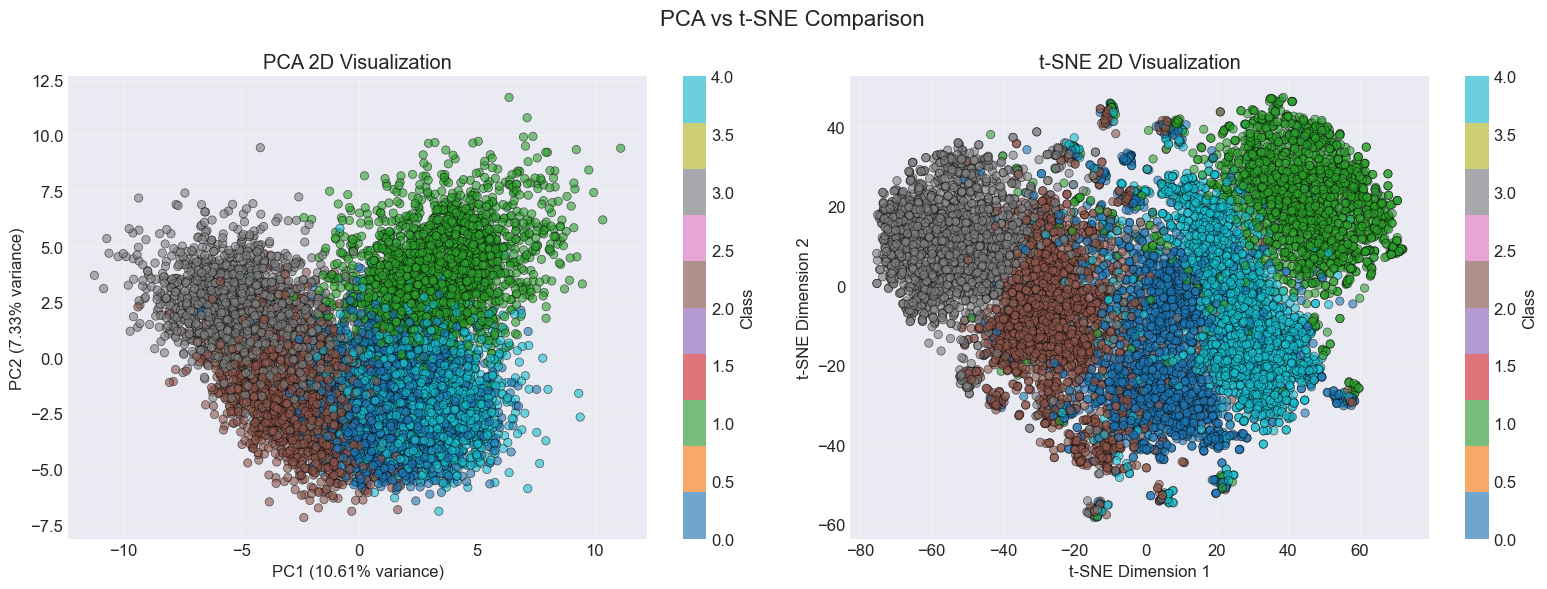

In [18]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA subplot
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=y, cmap='tab10', alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('PCA 2D Visualization')
axes[0].grid(True, alpha=0.3)

# t-SNE subplot
scatter2 = axes[1].scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], 
                          c=y, cmap='tab10', alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('t-SNE 2D Visualization')
axes[1].grid(True, alpha=0.3)

# Add colorbars
plt.colorbar(scatter1, ax=axes[0], label='Class')
plt.colorbar(scatter2, ax=axes[1], label='Class')

plt.suptitle('PCA vs t-SNE Comparison', fontsize=16)
plt.tight_layout()
plt.savefig('figures/problem1/pca_vs_tsne_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**Comparison Analysis:**
- [Compare preservation of structure]
- [Compare cluster separation]
- [Compare computational efficiency]
- [Which method better reveals the data structure?]

---
## Problem 2: K-Means on Original Data (60 points)

### 2.a) Optimal K Selection (20 points)

In [19]:
# Test different values of k
k_range = range(2, 21)
sse_scores = []
silhouette_scores = []

print('Testing different k values...')
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, 
                   max_iter=300, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    sse_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    
    if k % 5 == 0:
        print(f'k={k} completed')

print('K-means testing completed!')

Testing different k values...
k=5 completed
k=10 completed
k=15 completed
k=20 completed
K-means testing completed!


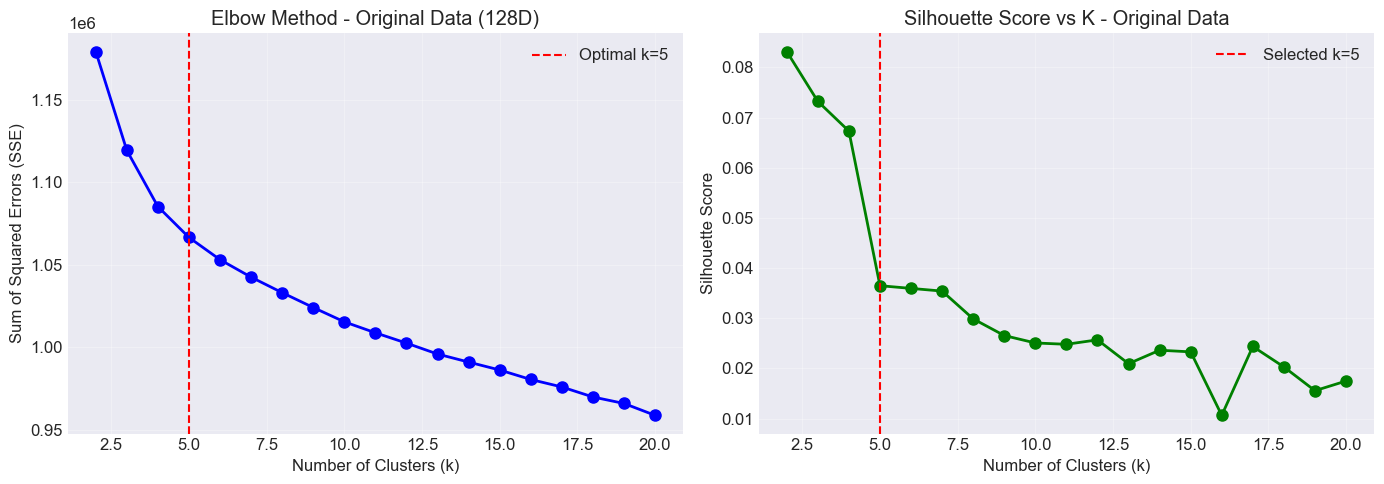


Optimal k selected: 5


In [20]:
# Plot Elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SSE plot
axes[0].plot(k_range, sse_scores, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Sum of Squared Errors (SSE)')
axes[0].set_title('Elbow Method - Original Data (128D)')
axes[0].grid(True, alpha=0.3)

# Mark the elbow point (you'll need to determine this)
optimal_k = 5  # Update this based on your analysis
axes[0].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0].legend()

# Silhouette scores plot
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs K - Original Data')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=optimal_k, color='r', linestyle='--', label=f'Selected k={optimal_k}')
axes[1].legend()

plt.tight_layout()
plt.savefig('figures/problem2/elbow_and_silhouette_original.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\nOptimal k selected: {optimal_k}')

**Justification for k selection:**
- [Explain your choice based on elbow point]
- [Consider silhouette scores]
- [Relate to ground truth if applicable]

### 2.b) Silhouette Analysis (20 points)

In [21]:
# Run K-means with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', 
                        n_init=10, max_iter=300, random_state=42)
labels_optimal = kmeans_optimal.fit_predict(X_scaled)

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(X_scaled, labels_optimal)
silhouette_avg = silhouette_score(X_scaled, labels_optimal)

print(f'Average silhouette score: {silhouette_avg:.3f}')

Average silhouette score: 0.036


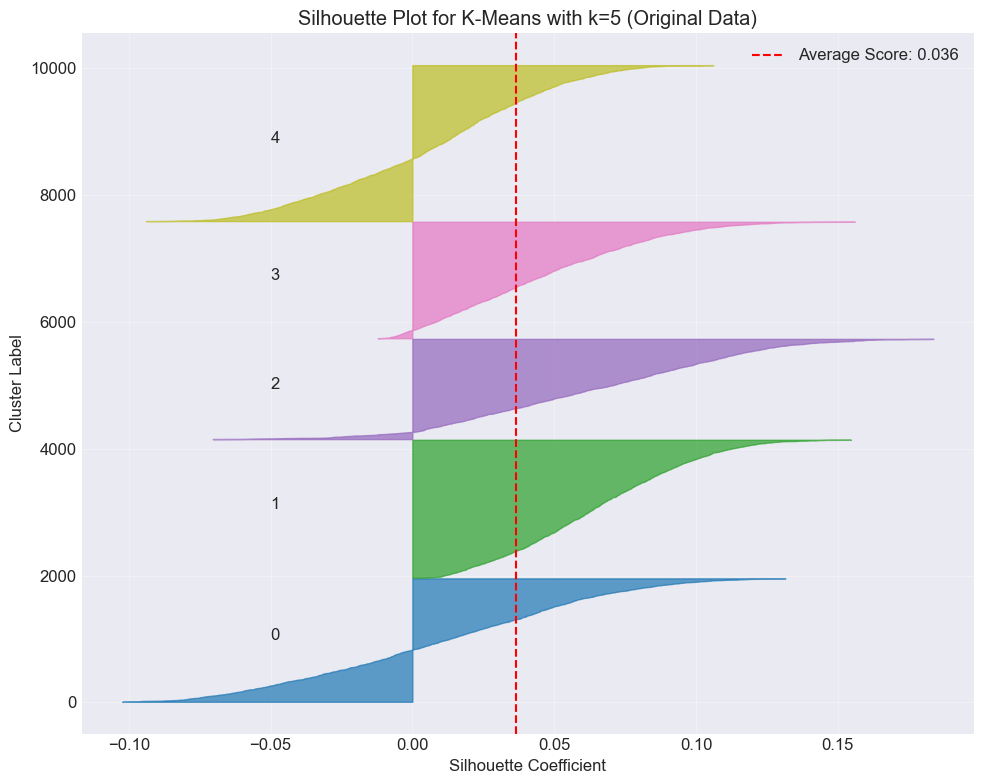

In [22]:
# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 8))

y_lower = 10
for i in range(optimal_k):
    # Get silhouette scores for cluster i
    cluster_silhouette_vals = silhouette_vals[labels_optimal == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.tab10(float(i) / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, cluster_silhouette_vals,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples

# Add average silhouette score line
ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
          label=f'Average Score: {silhouette_avg:.3f}')

ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster Label')
ax.set_title(f'Silhouette Plot for K-Means with k={optimal_k} (Original Data)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/problem2/silhouette_plot_original.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.c) Sample Identification and Visualization (20 points)

In [23]:
# Find core and boundary samples
core_samples = []
boundary_samples = []

# For each cluster, find the sample with highest silhouette (core)
for i in range(optimal_k):
    cluster_mask = labels_optimal == i
    cluster_silhouettes = silhouette_vals[cluster_mask]
    cluster_indices = np.where(cluster_mask)[0]
    
    # Get index of sample with highest silhouette in this cluster
    best_idx = cluster_indices[np.argmax(cluster_silhouettes)]
    core_samples.append(best_idx)

# Find boundary samples (lowest silhouette scores overall)
sorted_indices = np.argsort(silhouette_vals)
boundary_samples = sorted_indices[:2]  # 2 boundary samples

print(f'Core samples (one per cluster): {core_samples}')
print(f'Boundary samples: {boundary_samples.tolist()}')

# Print silhouette scores
for i, idx in enumerate(core_samples):
    print(f'Cluster {i} core sample {idx}: silhouette = {silhouette_vals[idx]:.3f}')
    
for idx in boundary_samples:
    print(f'Boundary sample {idx}: silhouette = {silhouette_vals[idx]:.3f}')

Core samples (one per cluster): [np.int64(3856), np.int64(4013), np.int64(3337), np.int64(2801), np.int64(1468)]
Boundary samples: [1611, 8292]
Cluster 0 core sample 3856: silhouette = 0.131
Cluster 1 core sample 4013: silhouette = 0.155
Cluster 2 core sample 3337: silhouette = 0.184
Cluster 3 core sample 2801: silhouette = 0.156
Cluster 4 core sample 1468: silhouette = 0.106
Boundary sample 1611: silhouette = -0.102
Boundary sample 8292: silhouette = -0.101


In [24]:
# Load images for visualization (if not already loaded)
# Uncomment and modify path as needed
# images = pd.read_csv('images.csv', header=None).values

# # Display sample images
# fig, axes = plt.subplots(2, max(len(core_samples), 2), figsize=(15, 6))

# # Display core samples
# for i, idx in enumerate(core_samples):
#     if i < axes.shape[1]:
#         img = images[idx].reshape(28, 28)  # Adjust dimensions as needed
#         axes[0, i].imshow(img, cmap='gray')
#         axes[0, i].set_title(f'Core C{labels_optimal[idx]}\nSil: {silhouette_vals[idx]:.3f}')
#         axes[0, i].axis('off')

# # Display boundary samples
# for i, idx in enumerate(boundary_samples):
#     if i < axes.shape[1]:
#         img = images[idx].reshape(28, 28)  # Adjust dimensions as needed
#         axes[1, i].imshow(img, cmap='gray')
#         axes[1, i].set_title(f'Boundary\nSil: {silhouette_vals[idx]:.3f}')
#         axes[1, i].axis('off')

# plt.suptitle('Core and Boundary Samples', fontsize=16)
# plt.tight_layout()
# plt.savefig('figures/problem2/sample_images_original.png', dpi=300, bbox_inches='tight')
# plt.show()

**Sample Analysis:**
- [Comment on visual similarity of core samples]
- [Explain why boundary samples are ambiguous]
- [Relate to clustering quality]

---
## Problem 3: K-Means on PCA-Reduced Data (40 points)

### 3.a) PCA Reduction to 20D (10 points)

Shape after PCA: (10000, 20)
Total variance explained: 50.31%


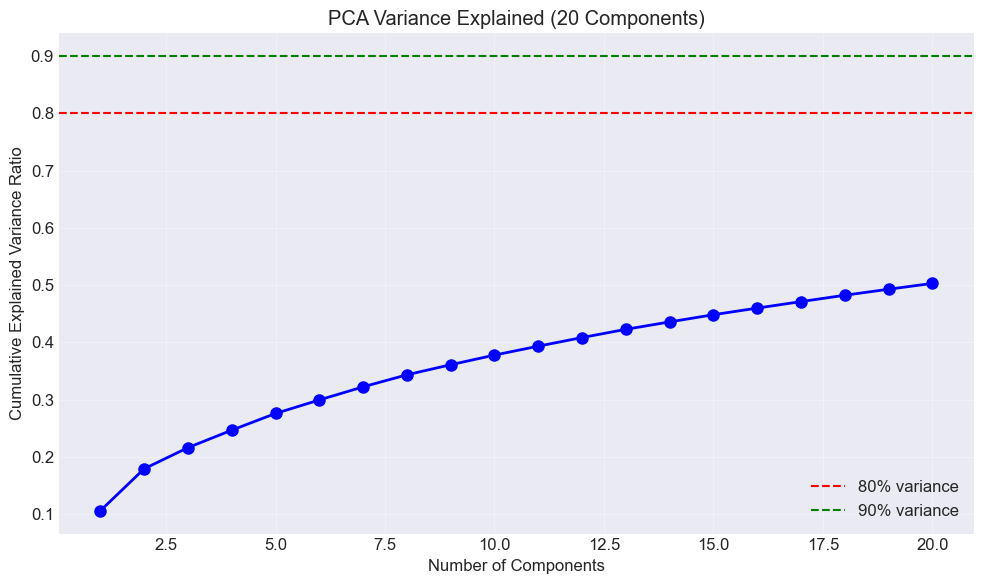

In [25]:
# Apply PCA to reduce to 20 dimensions
pca_20 = PCA(n_components=20, random_state=42)
X_pca_20 = pca_20.fit_transform(X_scaled)

print(f'Shape after PCA: {X_pca_20.shape}')
print(f'Total variance explained: {pca_20.explained_variance_ratio_.sum():.2%}')

# Plot cumulative variance explained
cumsum_var = np.cumsum(pca_20.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cumsum_var, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Variance Explained (20 Components)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.tight_layout()
plt.savefig('figures/problem3/pca_variance_explained.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.b) K-Means on PCA-Reduced Data (20 points)

In [26]:
# Test different values of k on PCA-reduced data
sse_scores_pca = []
silhouette_scores_pca = []

print('Testing K-means on PCA-reduced data...')
for k in k_range:
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', n_init=10,
                       max_iter=300, random_state=42)
    labels_pca = kmeans_pca.fit_predict(X_pca_20)
    
    sse_scores_pca.append(kmeans_pca.inertia_)
    silhouette_scores_pca.append(silhouette_score(X_pca_20, labels_pca))
    
    if k % 5 == 0:
        print(f'k={k} completed')

print('K-means on PCA data completed!')

Testing K-means on PCA-reduced data...
k=5 completed
k=10 completed
k=15 completed
k=20 completed
K-means on PCA data completed!


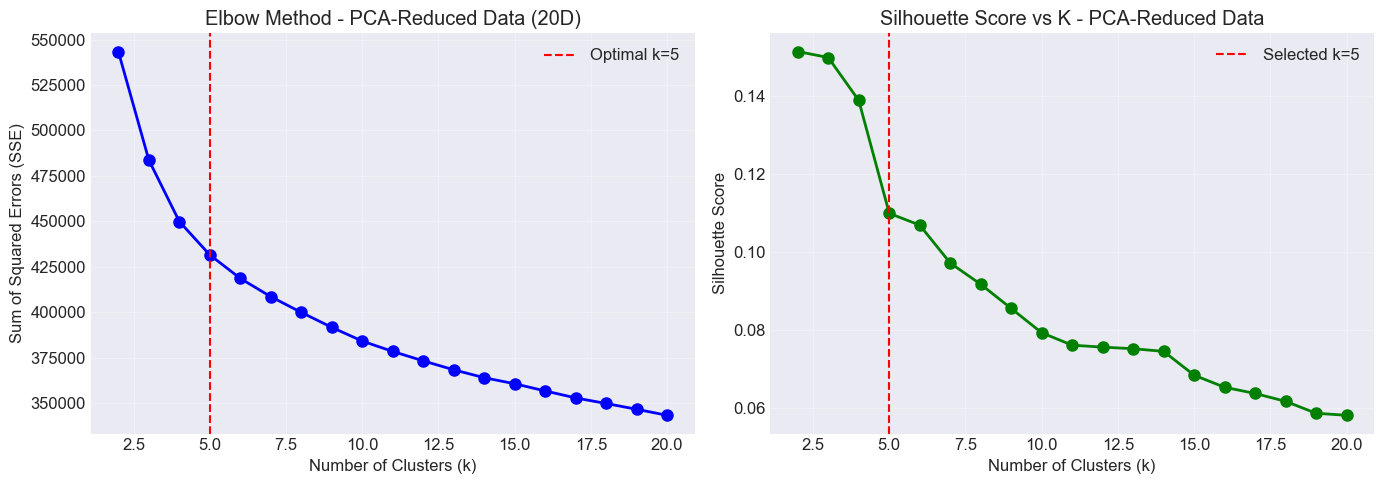


Optimal k selected for PCA data: 5


In [27]:
# Plot Elbow curve for PCA-reduced data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SSE plot
axes[0].plot(k_range, sse_scores_pca, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Sum of Squared Errors (SSE)')
axes[0].set_title('Elbow Method - PCA-Reduced Data (20D)')
axes[0].grid(True, alpha=0.3)

# Mark the elbow point
optimal_k_pca = 5  # Update based on your analysis
axes[0].axvline(x=optimal_k_pca, color='r', linestyle='--', label=f'Optimal k={optimal_k_pca}')
axes[0].legend()

# Silhouette scores plot
axes[1].plot(k_range, silhouette_scores_pca, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs K - PCA-Reduced Data')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=optimal_k_pca, color='r', linestyle='--', label=f'Selected k={optimal_k_pca}')
axes[1].legend()

plt.tight_layout()
plt.savefig('figures/problem3/elbow_and_silhouette_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\nOptimal k selected for PCA data: {optimal_k_pca}')

### 3.c) Silhouette Plot for PCA-Reduced Data (10 points)

In [28]:
# Run K-means with optimal k on PCA data
kmeans_pca_optimal = KMeans(n_clusters=optimal_k_pca, init='k-means++',
                            n_init=10, max_iter=300, random_state=42)
labels_pca_optimal = kmeans_pca_optimal.fit_predict(X_pca_20)

# Calculate silhouette scores
silhouette_vals_pca = silhouette_samples(X_pca_20, labels_pca_optimal)
silhouette_avg_pca = silhouette_score(X_pca_20, labels_pca_optimal)

print(f'Average silhouette score (PCA): {silhouette_avg_pca:.3f}')

Average silhouette score (PCA): 0.110


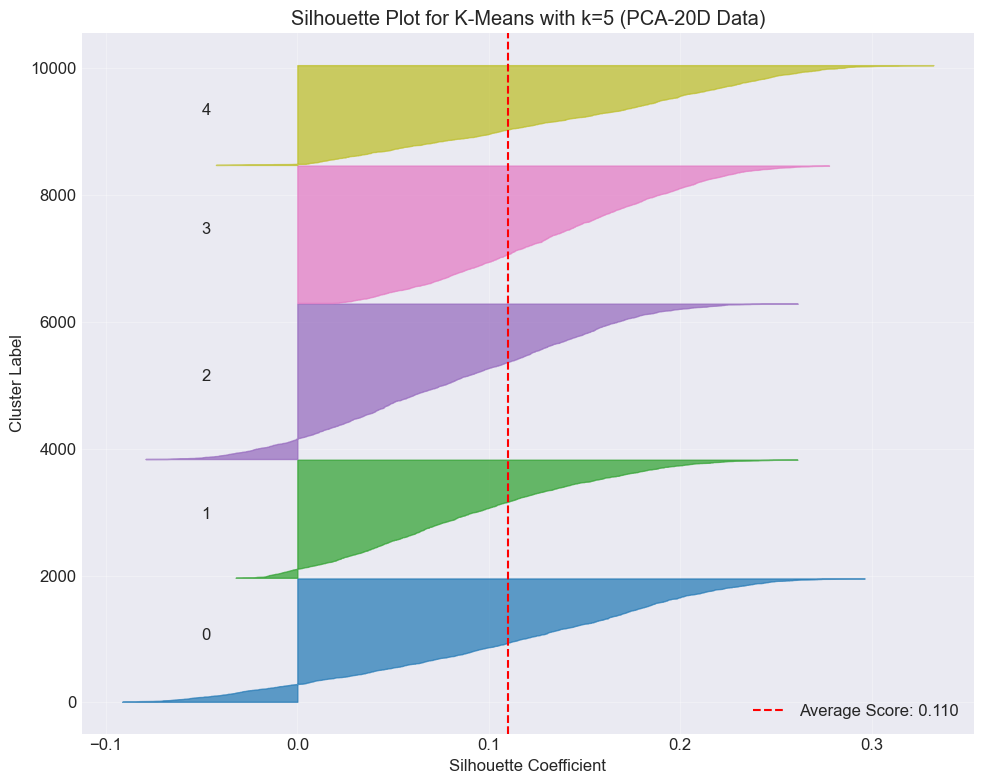

In [29]:
# Create silhouette plot for PCA data
fig, ax = plt.subplots(figsize=(10, 8))

y_lower = 10
for i in range(optimal_k_pca):
    cluster_silhouette_vals = silhouette_vals_pca[labels_pca_optimal == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.tab10(float(i) / optimal_k_pca)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, cluster_silhouette_vals,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg_pca, color="red", linestyle="--",
          label=f'Average Score: {silhouette_avg_pca:.3f}')

ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster Label')
ax.set_title(f'Silhouette Plot for K-Means with k={optimal_k_pca} (PCA-20D Data)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/problem3/silhouette_plot_pca.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Problem 4: Clustering Comparison (20 points)

In [30]:
# Calculate Adjusted Rand Index for both methods
ari_original = adjusted_rand_score(y, labels_optimal)
ari_pca = adjusted_rand_score(y, labels_pca_optimal)

print(f'ARI - Original Data (128D): {ari_original:.3f}')
print(f'ARI - PCA Data (20D): {ari_pca:.3f}')

# Measure computational time
start_time = time()
kmeans_original_time = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_original_time.fit(X_scaled)
time_original = time() - start_time

start_time = time()
kmeans_pca_time = KMeans(n_clusters=optimal_k_pca, random_state=42)
kmeans_pca_time.fit(X_pca_20)
time_pca = time() - start_time

print(f'\nTime - Original Data: {time_original:.3f} seconds')
print(f'Time - PCA Data: {time_pca:.3f} seconds')

ARI - Original Data (128D): 0.697
ARI - PCA Data (20D): 0.689

Time - Original Data: 0.060 seconds
Time - PCA Data: 0.021 seconds


In [31]:
# Create comparison table
comparison_data = {
    'Method': ['Original (128D)', 'PCA (20D)'],
    'Optimal k': [optimal_k, optimal_k_pca],
    'ARI Score': [f'{ari_original:.3f}', f'{ari_pca:.3f}'],
    'Avg Silhouette': [f'{silhouette_avg:.3f}', f'{silhouette_avg_pca:.3f}'],
    'Time (s)': [f'{time_original:.3f}', f'{time_pca:.3f}'],
    'Dimensionality': [128, 20]
}

comparison_df = pd.DataFrame(comparison_data)
print('\nClustering Methods Comparison:')
print(comparison_df.to_string(index=False))

# Save comparison table
comparison_df.to_csv('results/clustering_comparison.csv', index=False)


Clustering Methods Comparison:
         Method  Optimal k ARI Score Avg Silhouette Time (s)  Dimensionality
Original (128D)          5     0.697          0.036    0.060             128
      PCA (20D)          5     0.689          0.110    0.021              20


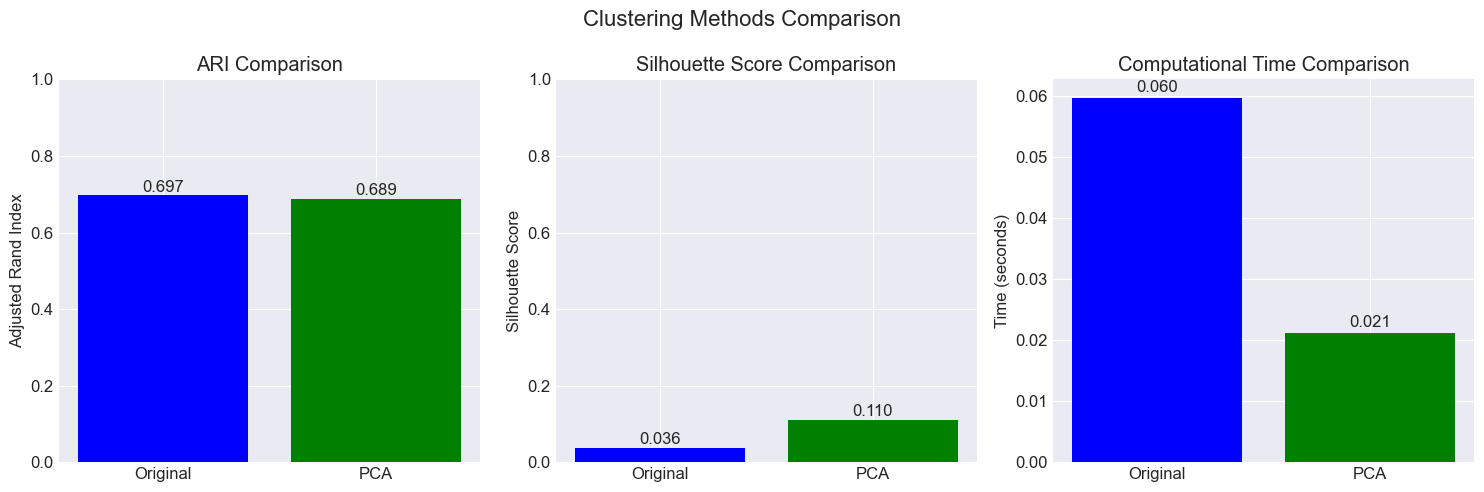

In [32]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# ARI comparison
axes[0].bar(['Original', 'PCA'], [ari_original, ari_pca], color=['blue', 'green'])
axes[0].set_ylabel('Adjusted Rand Index')
axes[0].set_title('ARI Comparison')
axes[0].set_ylim([0, 1])
for i, v in enumerate([ari_original, ari_pca]):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Silhouette comparison
axes[1].bar(['Original', 'PCA'], [silhouette_avg, silhouette_avg_pca], color=['blue', 'green'])
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score Comparison')
axes[1].set_ylim([0, 1])
for i, v in enumerate([silhouette_avg, silhouette_avg_pca]):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Time comparison
axes[2].bar(['Original', 'PCA'], [time_original, time_pca], color=['blue', 'green'])
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Computational Time Comparison')
for i, v in enumerate([time_original, time_pca]):
    axes[2].text(i, v + 0.001, f'{v:.3f}', ha='center')

plt.suptitle('Clustering Methods Comparison', fontsize=16)
plt.tight_layout()
plt.savefig('figures/problem4/method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**Best Method Justification:**
- [Compare ARI scores - which is closer to ground truth?]
- [Compare silhouette scores - which has better cluster quality?]
- [Compare computational efficiency]
- [Final recommendation with reasoning]

---
## Extra Credit: Combined Visualization (20 points)

In [33]:
# Determine best clustering method based on Problem 4
if ari_original > ari_pca:
    best_labels = labels_optimal
    best_method = "Original (128D)"
else:
    best_labels = labels_pca_optimal
    best_method = "PCA (20D)"

print(f"Using best method: {best_method}")

Using best method: Original (128D)


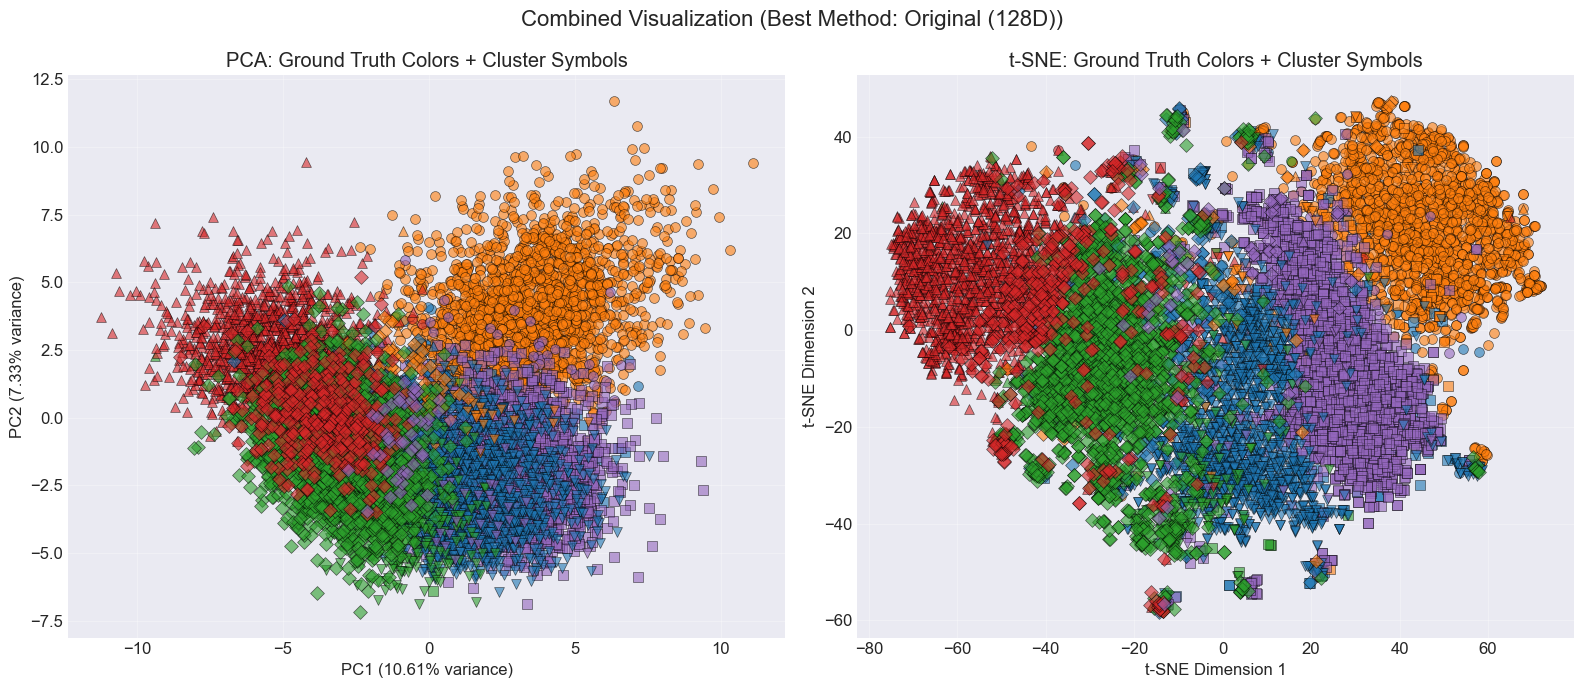

In [34]:
# Enhanced PCA visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Define markers for different clusters
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', '+', 'x']

# PCA plot
for cluster in np.unique(best_labels):
    mask = best_labels == cluster
    for true_class in np.unique(y):
        class_mask = y == true_class
        combined_mask = mask & class_mask
        if np.any(combined_mask):
            axes[0].scatter(X_pca_2d[combined_mask, 0], X_pca_2d[combined_mask, 1],
                          c=[plt.cm.tab10(true_class)], marker=markers[cluster % len(markers)],
                          s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('PCA: Ground Truth Colors + Cluster Symbols')
axes[0].grid(True, alpha=0.3)

# t-SNE plot
for cluster in np.unique(best_labels):
    mask = best_labels == cluster
    for true_class in np.unique(y):
        class_mask = y == true_class
        combined_mask = mask & class_mask
        if np.any(combined_mask):
            axes[1].scatter(X_tsne_2d[combined_mask, 0], X_tsne_2d[combined_mask, 1],
                          c=[plt.cm.tab10(true_class)], marker=markers[cluster % len(markers)],
                          s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('t-SNE: Ground Truth Colors + Cluster Symbols')
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Combined Visualization (Best Method: {best_method})', fontsize=16)
plt.tight_layout()
plt.savefig('figures/extra_credit/combined_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

**Extra Credit Analysis:**
- [Comment on agreement between clusters and ground truth]
- [Identify areas where clustering aligns with true classes]
- [Point out misclassified regions]
- [Explain what this reveals about the data structure]

---
## Summary and Conclusions

### Key Findings:
1. **Dimensionality Reduction:**
   - [Summary of PCA vs t-SNE]

2. **Clustering Performance:**
   - [Original vs PCA-reduced comparison]

3. **Best Method:**
   - [Final recommendation with justification]

### Insights from Lecture Concepts:
- [Reference curse of dimensionality]
- [Discuss bias-variance tradeoff]
- [Mention convergence criteria]
- [Other relevant concepts]